<a href="https://colab.research.google.com/github/z-xylym/LSTM-learning/blob/main/lstm_rumor_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()


Saving rumors_v170613.json to rumors_v170613.json


In [9]:
filename = list(uploaded.keys())[0]


In [7]:
import json
from google.colab import files



In [10]:
data = []
with open(filename, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data.append(json.loads(line.strip()))  # 解析 JSON
        except json.JSONDecodeError as e:
            print(f"JSON 解析错误: {e}")

# 4. 输出数据的前5条，检查是否正确
print(f"总共有 {len(data)} 条谣言数据")
print(json.dumps(data[:5], indent=2, ensure_ascii=False))  # 美化输出前5条数据

总共有 31669 条谣言数据
[
  {
    "rumorCode": "K1CaN8wJj76ol",
    "title": "@隆闯天涯 举报@浅雪深洋 不实信息",
    "informerName": "隆闯天涯",
    "informerUrl": "http://weibo.com/u/1842734325",
    "rumormongerName": "浅雪深洋",
    "rumormongerUrl": "http://weibo.com/u/2592892063",
    "rumorText": "急找孩子，求转 实验小学寻人启事13930886687帮忙扩散，今天上午一个三岁多小女孩在锦绣花园小区附近被人拐走了，小女孩能说出她爸爸的手机号码 从监控上看是被一个四十多岁男人抱走了现大人都急疯了 有知情者请告之 万分感谢 看到信息的兄弟姐妹留意一下 联系人 张静杰13930886687如果看一眼懒得 ",
    "visitTimes": 3,
    "result": "经查，该微博称“有孩子被抢”不实，类似消息近两年在网上广为流传且都已经被当地警方辟谣，详情：http://weibo.com/2656274875/CodNboTCH，被举报人构成“发布不实信息”，虽无即时危险，但应予澄清，现根据《微博社区管理规定》 （http://service.account.weibo.com/roles/guiding）第19条，予以标识处理。",
    "publishTime": "2016-06-15 09:02"
  },
  {
    "rumorCode": "K1CaN8wJj76ok",
    "title": "@隆闯天涯 举报@cat精品微店 不实信息",
    "informerName": "隆闯天涯",
    "informerUrl": "http://weibo.com/u/1842734325",
    "rumormongerName": "cat精品微店",
    "rumormongerUrl": "http://weibo.com/u/5722939786",
    "rumorText": "急帮忙转寻人启示13759695559帮忙扩散，今天上午一个三岁多小女孩在世

In [12]:
pip install pkuseg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pkuseg: filename=pkuseg-0.0.25-cp311-cp311-linux_x86_64.whl size=50751331 sha256=86f7121f9728843e87222bc7d04010ddc2bdf540c44e23bbcea82c8d0843d9fa
  Stored in directory: /root/.cache/pip/wheels/6e/b9/d9/3cfceef165811a9dfc46c94ab798e429cf413de917aba799ca
Successfully built pkuseg


In [14]:
pip install config

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import  torch
import jieba
import bz2
import  os,re
import gensim
import pkuseg
import numpy as np
from gensim.models import KeyedVectors   #gensim用来加载预训练词向量
import config as config



In [16]:
from google.colab import files
uploaded = files.upload()

Saving ced_dataset.txt to ced_dataset.txt


In [28]:
#解压预训练好的词向量bz2文件
def bz2Decompress():
    if os.path.exists ("/content/sgns.weibo.bigram.bz2") == False:
        with open ("/content/sgns.weibo.bigram.bz2", 'wb') as new_file, open ("/content/sgns.weibo.bigram.bz2", 'rb') as file:
            decompressor = bz2.BZ2Decompressor ()
            for data in iter (lambda: file.read (100 * 1024), b''):
                new_file.write (decompressor.decompress (data))

In [44]:
import bz2
import os

def bz2Decompress():
    compressed_file_path = "/content/sgns.weibo.bigram.bz2"
    output_file_path = "/content/sgns.weibo.bigram"  # 指定解压后的文件路径

    # 检查压缩文件是否存在
    if not os.path.exists(compressed_file_path):
        print(f"Error: The file {compressed_file_path} does not exist.")
        return

    # 解压过程
    with open(output_file_path, 'wb') as new_file:
        with open(compressed_file_path, 'rb') as file:
            decompressor = bz2.BZ2Decompressor()
            for data in iter(lambda: file.read(100 * 1024), b''):
                new_file.write(decompressor.decompress(data))

    # 检查解压后的文件是否存在
    if os.path.exists(output_file_path):
        print(f"File successfully decompressed to: {output_file_path}")
    else:
        print("Error: Decompression failed or file not found.")

# 调用解压函数
bz2Decompress()



File successfully decompressed to: /content/sgns.weibo.bigram


In [45]:
if os.path.exists("/content/sgns.weibo.bigram"):
    print("Decompression successful!")
else:
    print("Decompression failed!")


Decompression successful!


In [61]:
from google.colab import files
uploaded = files.upload()

Saving stopwords.txt to stopwords.txt


In [46]:
#从 ced_dataset.txt 中读取微博数据，分为 label（标签）和 content（文本内容）
def get_df():
    weibo = pd.read_csv ('/content/ced_dataset.txt', sep='\t', names=['label', 'content'], encoding='utf-8')
    weibo = weibo.dropna ()  # 删除缺失值
    return  weibo['label'].values.tolist(),weibo['content'].values.tolist()

In [47]:
#使用 jieba 进行中文分词，把一条微博拆分成多个词
def jieba_cut(contents):
    contents_S=[]
    for line in contents:
        current_segment=jieba.lcut(line)#列表，元素为分割出来的词
        contents_S.append (current_segment)
    return contents_S


In [48]:
#使用 pkuseg 进行中文分词,选择领域，并去除标点符号
def pkuseg_cut(contents,model_name="web"):
    seg = pkuseg.pkuseg (model_name='web')  # 程序会自动下载所对应的细领域模型
    contents_S = []
    for line in contents:
        line = re.sub ("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", line)
        current_segment = jieba.lcut (line)  # 列表，元素为分割出来的词
        contents_S.append(current_segment)
    return contents_S

In [63]:
#获取停用词表（get_stopwords()）
def get_stopwords():
    stopwords = pd.read_csv ("/content/stopwords.txt", index_col=False, sep="\t", quoting=3, names=['stopword'],
                             encoding='utf-8')
    return  set(stopwords['stopword'].values.tolist())

In [50]:
#去除停用词  获取停用词表（get_stopwords()）
去除停用词（drop_stopwords()）
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(str(word))    #str()转换为字符串##记录所有line_clean中的词
        contents_clean.append(line_clean)
    return contents_clean,all_words

In [57]:
#加载 sgns.weibo.bigram 预训练的微博中文词向量；获取每个词的向量表示（如 word2vec["中国"] 返回一个 300 维的向量）。
def get_word2vec():
    if os.path.exists("/content/sgns.weibo.bigram") == False:
        bz2Decompress()
    word2vec=KeyedVectors.load_word2vec_format('/content/sgns.weibo.bigram',binary=False,unicode_errors="ignore")
    return word2vec

In [52]:
#返回预处理后的（labels，index)=>([1},[234 1234])把分词后的文本转换为索引列表（即word2vec.key_to_index["中国"] → 234）。只保留前 num_words个高频词，其余词用0代替。
def key_to_index(contents,word2vec,num_words):
    '''
    :param contents:
    :param word2vec:预训练好的词向量模型，词向量根据使用频率降序排列
    :param num_words: 最大词汇数，选择使用前new_words个使用评率最高的词
    :return:
    '''
    train_tokens=[]
    contents_S = pkuseg_cut(contents)
    stopword = get_stopwords ()
    contents_clean, all_words = drop_stopwords (contents_S, stopword)
    for line_clean in contents_clean:
        for i, key in enumerate(line_clean):
            try:
                index=word2vec.key_to_index[key]
                if index<num_words:
                    line_clean[i]=word2vec.key_to_index[key]
                else:
                    line_clean[i] =0  #超出前num_words个词用0代替
            except KeyError:  #如果词不在字典中，则输出0
                line_clean[i]=0
        train_tokens.append(line_clean)
    return train_tokens


In [53]:
# 返回预处理后的（labels，contents)=>([1},[求 转发])
def labels_contents():
    labels, contents = get_df()
    contents_S = jieba_cut (contents)
    stopword = get_stopwords ()
    contents_clean, all_words = drop_stopwords (contents_S, stopword)
    contents_clean=[" ".join (x) for x in contents_clean]
    return labels, contents_clean

In [54]:
def get_maxlength(train_tokens):
    num_tokens = [len (tokens) for tokens in train_tokens]
    num_tokens = np.array (num_tokens)
    # 取tokens平均值并加上两个tokens的标准差，
    # 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
    max_tokens = np.mean (num_tokens) + 2 * np.std (num_tokens)
    max_tokens = int (max_tokens)
    return max_tokens


In [55]:
def padding_truncating(train_tokens,maxlen):
    for i,token in enumerate(train_tokens):
        if len(token)>maxlen:
            train_tokens[i]=token[len(token)-maxlen:]
        elif len(token)<maxlen:
            train_tokens[i]=[0]*(maxlen-len(token))+token
    return train_tokens

In [64]:
#config.py的内容，这里只是显示而已，后续直接调用Py文件来用
import torch




num_words =50000  #最大词汇数，选择使用前new_words个使用评率最高的词
maxlength =58     #文本最大长度,utils包中的get_maxlength() 方法获得通过 ,取tokens平均值并加上两个tokens的标准差，
                                     # 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本

embedding_dim = 300 #词向量维度
lstm_hidden_size=128  #LSTM 隐含层size
lstm_num_layers=2     #LSTM 层数
lstm_bidirectional=True #LSTM是否为双向
lr=1e-3    #学习率

dropout = 0.2  #随机置零的概率
batch_size = 64
early_stop_cnt=6   #验证集准确率不提升时最多等待epoch，早停
epoch=30           #迭代次数


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [77]:
from google.colab import files
uploaded = files.upload()


Saving config.py to config.py


In [80]:
!ls -l /content


total 753736
-rw-r--r-- 1 root root   1026143 Feb 10 13:58 ced_dataset.txt
-rw-r--r-- 1 root root       808 Feb 10 15:41 config.py
drwx------ 6 root root      4096 Feb 10 12:11 drive
-rw-r--r-- 1 root root  34155221 Feb 10 12:14 rumors_v170613.json
drwxr-xr-x 1 root root      4096 Feb  6 14:19 sample_data
-rw-r--r-- 1 root root 557111141 Feb 10 14:36 sgns.weibo.bigram
-rw-r--r-- 1 root root 179490373 Feb 10 14:07 sgns.weibo.bigram.bz2
-rw-r--r-- 1 root root     17672 Feb 10 15:29 stopwords.txt


In [82]:
sys.path.insert(0, "/content")
import config
print(config.num_words)  # 确保它能正确打印数值


50000


In [81]:
import sys
if "config" in sys.modules:
    del sys.modules["config"]


In [83]:
exec(open("/content/config.py").read())
print(num_words)


50000


In [85]:
#创建一个词向量矩阵，形状为 (50000, 300)，用于深度学习中的 Embedding Layer。
def get_embedding(word2vec,num_words=50000,embedding_dim=300):
    '''
    :param num_words: 只选择使用前50k个使用频率最高的词
    :param embedding_dim: 词向量维度
    :param word2vec: 预训练好的词向量模型
    :return:
    '''
    embedding_matrix = np.zeros ((num_words, embedding_dim))
    # embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
    # 维度为 50000 * 300
    for i in range (num_words):
        # embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]#前50000个index对应的词的词向量
        embedding_matrix[i, :] = word2vec[i]  # 前50000个index对应的词的词向量
    embedding_matrix = embedding_matrix.astype ('float32')
    return torch.from_numpy(embedding_matrix)

word2vec=get_word2vec()

embedding=get_embedding(word2vec,num_words=config.num_words,embedding_dim=config.embedding_dim)

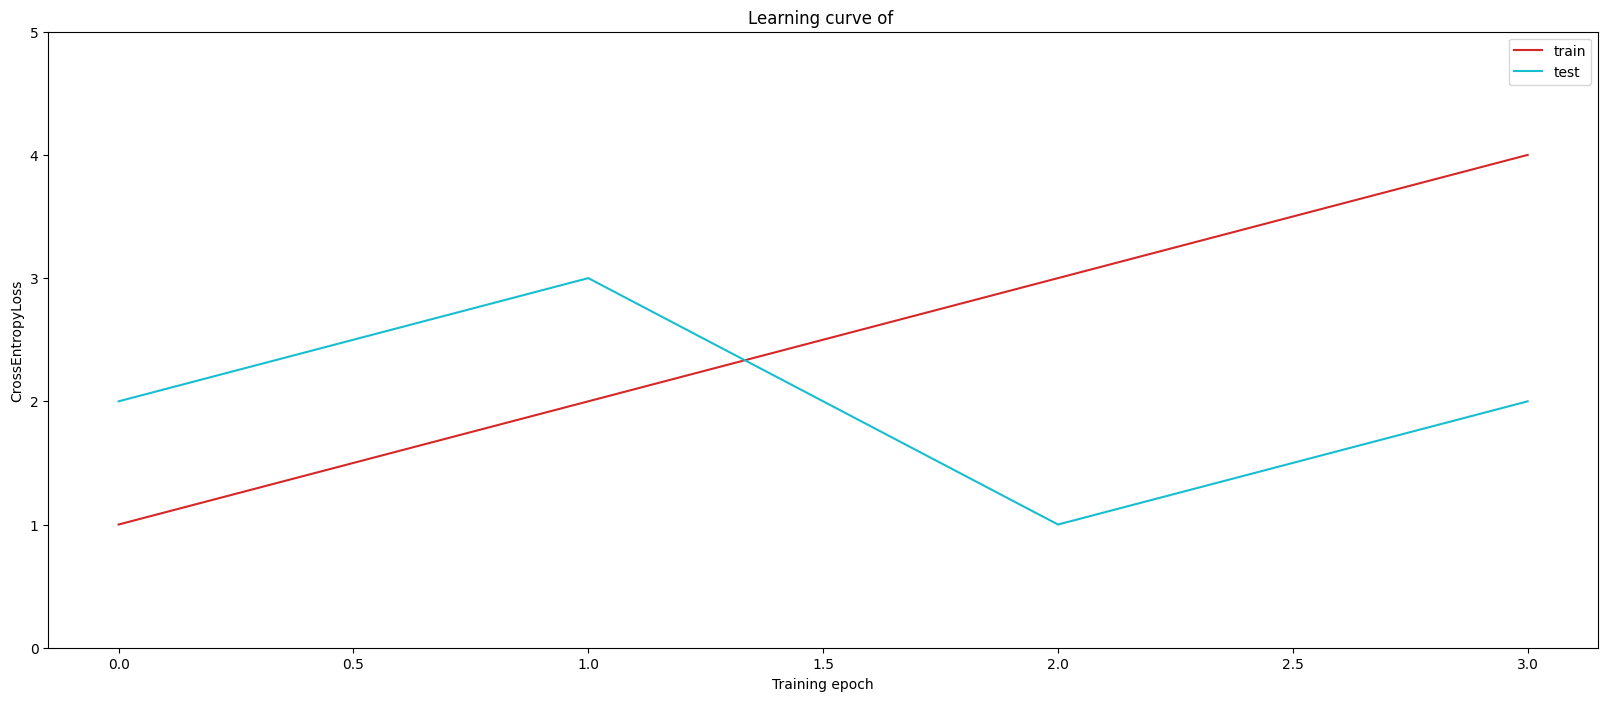

In [86]:
#绘制训练集和测试集的损失变化曲线，用于观察模型收敛情况。
def plot_learning_curve(train_loss,test_loss, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''

    plt.figure(figsize=(20, 8))
    plt.plot(train_loss, c='tab:red', label='train')
    plt.plot(test_loss, c='tab:cyan', label='test')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training epoch')
    plt.ylabel('CrossEntropyLoss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

if __name__ == '__main__':
    plot_learning_curve([1,2,3,4],[2,3,1,2])
    # labels,contents=labels_contents()
    # print(labels[:5])
    # print(contents[:5])

In [93]:
from google.colab import files
uploaded = files.upload()

Saving lstm_model.py to lstm_model.py


In [96]:
from google.colab import files
uploaded = files.upload()

Saving utils.py to utils.py


In [111]:
from google.colab import files
uploaded = files.upload()

Saving dataset.py to dataset.py


In [97]:
#对lstm.py的展示，后续只调用这个py，这里只是展示
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils as utils
import config as config



class LSTM_Model(nn.Module):
    def __init__(self):
        super(LSTM_Model, self).__init__()
        self.embedding=nn.Embedding.from_pretrained(utils.embedding,freeze=True)

        self.lstm = nn.LSTM(input_size=config.embedding_dim,  # 300
                            hidden_size=config.lstm_hidden_size,  # 128
                            num_layers=config.lstm_num_layers,  # 2
                            batch_first=True,
                            bidirectional=config.lstm_bidirectional,
                            dropout=config.dropout)  # 0.2
        self.fc1 = nn.Linear(config.lstm_hidden_size * 2, config.lstm_hidden_size)  # [128*2,128]
        self.fc2 = nn.Linear(config.lstm_hidden_size, 2)  # [128,2]

    def forward(self, input):
        """
        :param input: [batch_size,max_len],其中max_len表示每个句子有多少单词
        :return:
        """

        x = self.embedding(input)  # [batch_size,max_len,embedding_dim]
        # 经过lstm层，x:[batch_size,max_len,2*hidden_size]
        # h_n,c_n:[2*num_layers,batch_size,hidden_size]
        out, (h_n, c_n) = self.lstm(x)

        # 获取两个方向最后一次的h，进行concat
        output_fw = h_n[-2, :, :]  # [batch_size,hidden_size]
        output_bw = h_n[-1, :, :]  # [batch_size,hidden_size]
        out_put = torch.cat([output_fw, output_bw], dim=-1)  # [batch_size,hidden_size*2]

        out_fc1 = F.relu(self.fc1(out_put))  # []
        out_put = self.fc2(out_fc1)
        return out_put

In [114]:
#强制更新改过的utils
import importlib
import utils
importlib.reload(utils)



<module 'utils' from '/content/utils.py'>

In [129]:
#强制更新改过的dataset
import importlib
import dataset  # 确保使用正确的模块名称

importlib.reload(dataset)


<module 'dataset' from '/content/dataset.py'>

In [115]:
from utils import get_df


In [127]:
import torch
import utils as utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import config as config

from sklearn.preprocessing import LabelEncoder

class RummorDataset(Dataset):

    def __init__(self, model="train"):
        super(RummorDataset, self).__init__()

        # 读取数据
        self.labels, self.contents = utils.get_df()
        # 使用LabelEncoder将标签从字符串转换为数字
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        # 预处理文本数据
        self.contents = utils.key_to_index(self.contents, utils.word2vec, config.num_words)

        self.maxlen = utils.get_maxlength(self.contents)
        self.contents = utils.padding_truncating(self.contents, self.maxlen)

        # 切分训练集和测试集
        x_train, x_test, y_train, y_test = train_test_split(self.contents, self.labels, test_size=0.2, shuffle=True, random_state=0)

        if model == "train":
            self.contents = x_train
            self.labels = y_train
        elif model == "test":
            self.contents = x_test
            self.labels = y_test

    def __getitem__(self, item):
        # 将文本内容转换为数值索引形式，并转换为张量
        content_tensor = torch.tensor(self.contents[item], dtype=torch.long)
        # 转换后的标签也是数字，直接转换为张量
        label_tensor = torch.tensor(self.labels[item], dtype=torch.long)
        return content_tensor, label_tensor

    def __len__(self):
        return len(self.contents)


In [123]:
import torch
from lstm_model import LSTM_Model
from dataset import RummorDataset
import config as config
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataset import  get_dataloader
from torch.nn import CrossEntropyLoss
from utils import  plot_learning_curve
device = config.device

In [124]:
def train(epoch,model,loss_fn,optimizer,train_dataloader):
    model.train()
    loss_list = []
    train_acc = 0
    train_total = 0
    loss_fn.to(device)
    bar = tqdm(train_dataloader, total=len(train_dataloader))  #配置进度条
    for idx, (input, target) in enumerate(bar):
        input = input.to(device)
        target = target.to(device)
        output = model(input)
        loss =loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        loss_list.append (loss.cpu().item())
        optimizer.step()
        # 准确率
        output_max = output.max (dim=-1)  # 返回最大值和对应的index
        pred = output_max[-1]  # 最大值的index
        train_acc += pred.eq (target).cpu ().float ().sum ().item ()
        train_total += target.shape[0]
    acc = train_acc / train_total
    print("train epoch:{}  loss:{:.6f} acc:{:.5f}".format(epoch, np.mean(loss_list),acc))
    return acc,np.mean(loss_list)

In [125]:
def test(model,loss_fn,test_dataloader):
    model.eval()
    loss_list = []
    test_acc=0
    test_total=0
    loss_fn.to (device)
    with torch.no_grad():
        for input, target in test_dataloader:
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = loss_fn(output, target)
            loss_list.append(loss.item())
            # 准确率
            output_max = output.max(dim=-1) #返回最大值和对应的index
            pred = output_max[-1]  #最大值的index
            test_acc+=pred.eq(target).cpu().float().sum().item()
            test_total+=target.shape[0]
        acc=test_acc/test_total
        print("test loss:{:.6f},acc:{}".format(np.mean(loss_list), acc))
    return acc,np.mean(loss_list)

In [131]:
mkdir model

The model has 868,738 trainable parameters


100%|██████████| 43/43 [00:25<00:00,  1.71it/s]


train epoch:0  loss:0.549846 acc:0.70210
test loss:0.461895,acc:0.7979351032448377
save model,acc:0.7979351032448377


100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


train epoch:1  loss:0.387405 acc:0.83093
test loss:0.422038,acc:0.8112094395280236
save model,acc:0.8112094395280236


100%|██████████| 43/43 [00:26<00:00,  1.61it/s]


train epoch:2  loss:0.373519 acc:0.83647
test loss:0.406208,acc:0.8215339233038348
save model,acc:0.8215339233038348


100%|██████████| 43/43 [00:25<00:00,  1.70it/s]


train epoch:3  loss:0.273737 acc:0.88852
test loss:0.415920,acc:0.8230088495575221
save model,acc:0.8230088495575221


100%|██████████| 43/43 [00:25<00:00,  1.70it/s]


train epoch:4  loss:0.231201 acc:0.90735
test loss:0.421725,acc:0.8348082595870207
save model,acc:0.8348082595870207


100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


train epoch:5  loss:0.195091 acc:0.92322
test loss:0.545009,acc:0.8171091445427728


100%|██████████| 43/43 [00:27<00:00,  1.58it/s]


train epoch:6  loss:0.185363 acc:0.92839
test loss:0.506607,acc:0.8244837758112095


100%|██████████| 43/43 [00:24<00:00,  1.76it/s]


train epoch:7  loss:0.091786 acc:0.96456
test loss:0.542838,acc:0.8421828908554573
save model,acc:0.8421828908554573


100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


train epoch:8  loss:0.066556 acc:0.97785
test loss:0.668649,acc:0.8421828908554573


100%|██████████| 43/43 [00:24<00:00,  1.77it/s]


train epoch:9  loss:0.049151 acc:0.98302
test loss:0.748020,acc:0.8466076696165191
save model,acc:0.8466076696165191


100%|██████████| 43/43 [00:29<00:00,  1.45it/s]


train epoch:10  loss:0.041561 acc:0.98523
test loss:0.758365,acc:0.8392330383480826


100%|██████████| 43/43 [00:25<00:00,  1.68it/s]


train epoch:11  loss:0.035448 acc:0.98745
test loss:0.849759,acc:0.8289085545722714


100%|██████████| 43/43 [00:25<00:00,  1.70it/s]


train epoch:12  loss:0.026377 acc:0.99077
test loss:0.884491,acc:0.8303834808259587


100%|██████████| 43/43 [00:26<00:00,  1.60it/s]


train epoch:13  loss:0.015197 acc:0.99520
test loss:0.897676,acc:0.8333333333333334


100%|██████████| 43/43 [00:24<00:00,  1.76it/s]


train epoch:14  loss:0.020603 acc:0.99372
test loss:0.838263,acc:0.8377581120943953


100%|██████████| 43/43 [00:27<00:00,  1.56it/s]


train epoch:15  loss:0.011842 acc:0.99557
test loss:0.949509,acc:0.8289085545722714


100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


train epoch:16  loss:0.018548 acc:0.99483
test loss:0.914401,acc:0.8362831858407079


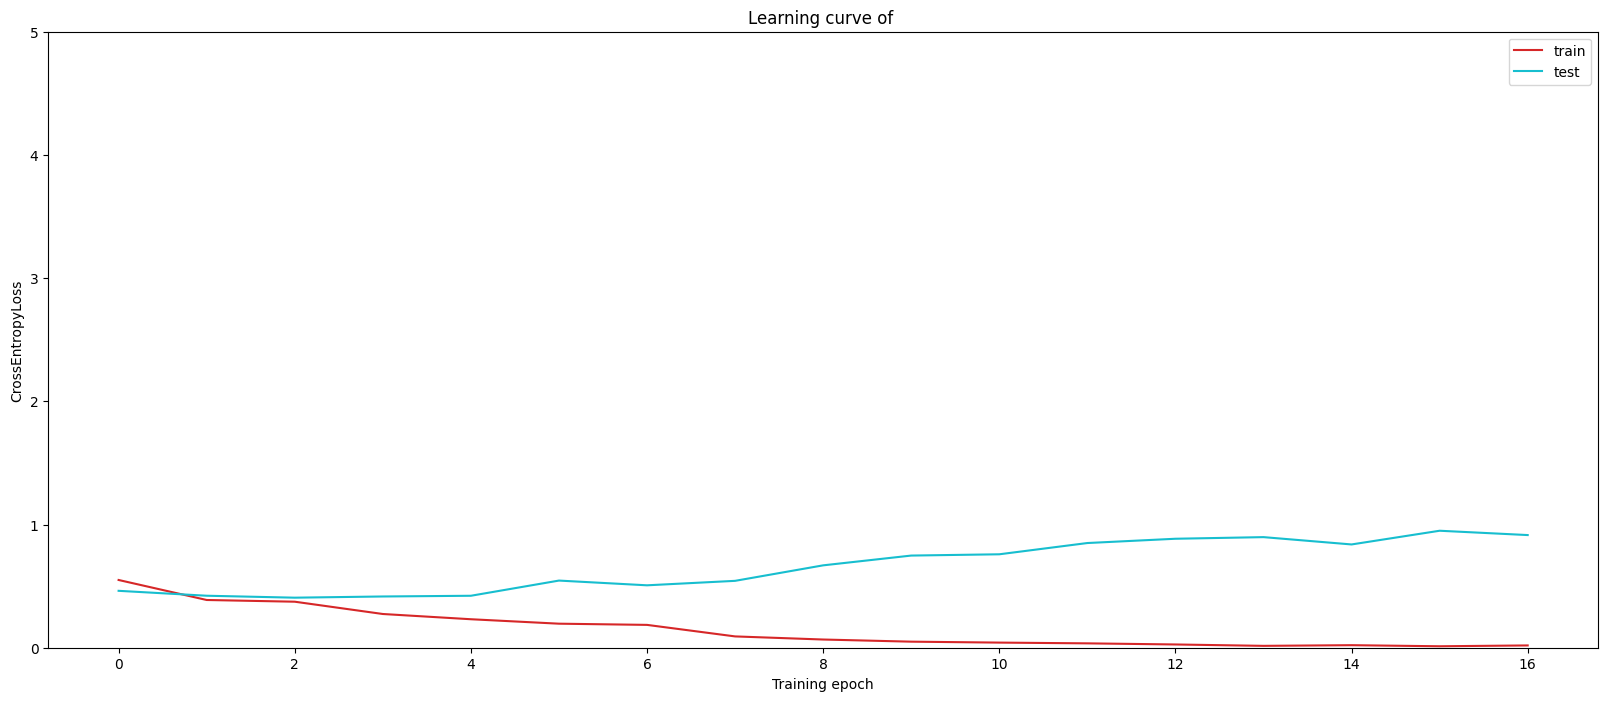

In [132]:
if __name__ == '__main__':
    model = LSTM_Model().to(device)
    count_parameters=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {count_parameters:,} trainable parameters')
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    train_dataloader = get_dataloader(model='train')
    test_dataloader = get_dataloader(model='test')
    loss_fn=CrossEntropyLoss()
    best_acc=0
    early_stop_cnt=0
    train_loss_list=[]
    test_loss_list=[]
    for epoch in range(config.epoch):
        train_acc,train_loss=train(epoch,model,loss_fn,optimizer,train_dataloader)
        test_acc,test_loss=test(model,loss_fn,test_dataloader)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save(model.state_dict(), 'model/model.pkl')
            print("save model,acc:{}".format(best_acc))
            early_stop_cnt=0
        else:
            early_stop_cnt+=1
        if early_stop_cnt>config.early_stop_cnt:
            break
    plot_learning_curve(train_loss_list,test_loss_list)